#Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
!pip install -q transformers
!pip install -q datasets
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import load_metric
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np        
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
from PIL import Image
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report



#Download Data

In [2]:
!gdown https://drive.google.com/uc?id=1L787y_gjEaw45Yv41oFGkFYW8gTj1h9P

Downloading...
From: https://drive.google.com/uc?id=1L787y_gjEaw45Yv41oFGkFYW8gTj1h9P
To: /content/dialect_dataset_cleaned.csv
100% 52.0M/52.0M [00:00<00:00, 184MB/s]


#Read Data

In [3]:
df = pd.read_csv("/content/dialect_dataset_cleaned.csv")

In [4]:
df.head()

,dialect,text
0,TN,ناس بكري قالوا طيح وشوف شكون يوقف معاك غيب وشو...
1,TN,تهبل والله فنانه مبدعه انت ماشاء الله
2,TN,الله يبارك فيك يعيشك
3,TN,عيدكم مبروك وسنين دايمه دلوع
4,TN,الله يسلمك دلوع الغاليه ويمتعك بالصحه والعافيه...


In [5]:
df.isna().sum()

dialect      0
text       172
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df = df.sample(100000,replace=True,random_state=123)

In [36]:
df.to_csv("sample.csv",index=False)

## Split data

In [ ]:
!gdown https://drive.google.com/uc?id=1L52IF87VWMepCgeu1GejE_AhE1x6PSXT

In [103]:
df = pd.read_csv('/content/sample.csv')

In [9]:
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['dialect'], test_size=0.006, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

In [11]:
df_train = pd.DataFrame({'tweet':X_train,'dialect':y_train})
df_test = pd.DataFrame({'tweet':X_test,'dialect':y_test})
df_val = pd.DataFrame({'tweet':X_val,'dialect':y_val})

#Preparing data and model

In [18]:
df_train['dialect'].unique()

array(['BH', 'EG', 'PL', 'LY', 'SA', 'KW', 'LB', 'DZ', 'YE', 'MA', 'AE',
       'SY', 'OM', 'SD', 'IQ', 'JO', 'QA', 'TN'], dtype=object)

In [19]:
encode_labels = {d: i for i, d in enumerate(df_train['dialect'].unique())}

In [20]:
df_train['dialect'] = df_train['dialect'].map(encode_labels)
df_test['dialect'] = df_test['dialect'].map(encode_labels)
df_val['dialect'] = df_val['dialect'].map(encode_labels)

In [21]:
df_train.head()

,tweet,dialect
50551,طويل الشوق يبقي اغتراب,0
73522,اتفرجوا علي الماتش النهارده وشوف كميه التعليقا...,1
84440,قله ادب الناس هالفتره صايره اوڤرر,2
56746,اعطوني منفعه واحده داروها مليشيات طرابلس فايده...,3
66836,عظم جمال مسلسل تحس المسلسل اللي بعده حلو انا م...,4


In [22]:
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabert', num_labels=len(df_train['dialect'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabert')

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/717k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
sequence = []
for i in df_train['tweet'].tolist():
  sequence.append(len(tokenizer.encode(i)))
max_seq_len = max(sequence)

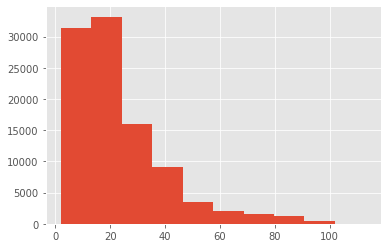

In [24]:
plt.hist(sequence);

In [25]:
max(sequence)

113

In [26]:
train = tokenizer(df_train['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val= tokenizer(df_val['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test = tokenizer(df_test['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [27]:
train_labels = df_train['dialect']
val_labels = df_val['dialect']
test_labels = df_test['dialect']

In [28]:
class QadiDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)


In [29]:
ds_train = QadiDataset(train, train_labels)
ds_val =  QadiDataset(val, val_labels)
ds_test = QadiDataset(test, test_labels)

In [30]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# def compute_metrics(eval_pred):
#   logits, labels = eval_pred
#   predictions = np.argmax(logits, axis=-1)
#   f1 = f1_score(labels, predictions, average='macro')
#   acc = accuracy_score(labels, predictions)
#   return {
#       'accuracy': acc,
#       'f1': f1
#   }

In [31]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=6,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,              
    load_best_model_at_end=True,
    evaluation_strategy = "epoch",
    save_strategy = 'epoch'
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,         
    eval_dataset=ds_val,            
    compute_metrics=compute_metrics
)

#Training

In [57]:
trainer.train()

***** Running training *****
  Num examples = 98406
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 9228
  Number of trainable parameters = 135207186


Epoch,Training Loss,Validation Loss,Accuracy
1,1.977800,1.812245,0.439638
2,1.649900,1.664030,0.470825
3,1.303300,1.640950,0.501006


***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1538
Configuration saved in ./results/checkpoint-1538/config.json
Model weights saved in ./results/checkpoint-1538/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-3076
Configuration saved in ./results/checkpoint-3076/config.json
Model weights saved in ./results/checkpoint-3076/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-4614
Configuration saved in ./results/checkpoint-4614/config.json
Model weights saved in ./results/checkpoint-4614/pytorch_model.bin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.977800,1.812245,0.439638
2,1.649900,1.664030,0.470825
3,1.303300,1.640950,0.501006
4,0.971900,1.687958,0.522133
5,0.728000,1.793136,0.537223
6,0.548400,1.889582,0.548290


***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-6152
Configuration saved in ./results/checkpoint-6152/config.json
Model weights saved in ./results/checkpoint-6152/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-7690
Configuration saved in ./results/checkpoint-7690/config.json
Model weights saved in ./results/checkpoint-7690/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 994
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-9228
Configuration saved in ./results/checkpoint-9228/config.json
Model weights saved in ./results/checkpoint-9228/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-4614 (score: 1.640950083732605).


TrainOutput(global_step=9228, training_loss=1.2474748018659139, metrics={'train_runtime': 10571.3341, 'train_samples_per_second': 55.853, 'train_steps_per_second': 0.873, 'total_flos': 3.429120871825387e+16, 'train_loss': 1.2474748018659139, 'epoch': 6.0})

## Save model checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/results/checkpoint-4614 /content/drive/MyDrive/sample100k-checkpoint-4614

In [ ]:
# trainer.save_model('./checkpoint842')

# Testing

In [62]:
preds = trainer.predict(ds_test)

***** Running Prediction *****
  Num examples = 600
  Batch size = 64


In [64]:
y_pred = [ np.argmax(i, axis=-1) for i  in preds[0]]
y_test = ds_test.labels

In [66]:
f1_score(y_test, y_pred, average='macro')

0.47501746109576826

In [68]:
accuracy_score(y_test, y_pred)

0.5233333333333333

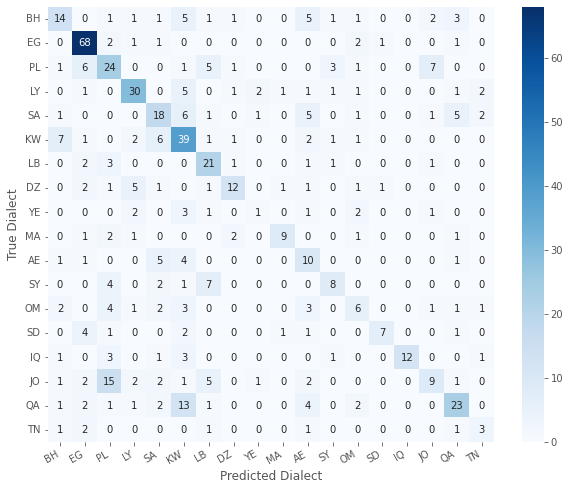

In [75]:
class_name = ['BH', 'EG', 'PL', 'LY', 'SA', 'KW', 'LB', 'DZ', 'YE', 'MA', 'AE','SY', 'OM', 'SD', 'IQ', 'JO', 'QA', 'TN']

def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(10, 8))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Dialect')
  plt.xlabel('Predicted Dialect');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

#Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabert')

In [33]:
Model_checkpoint = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/sample100k-checkpoint-4614/checkpoint-4614/")
inf_trainer = Trainer(
    model=Model_checkpoint,                       
    args=training_args,                 
    train_dataset=ds_train,        
    eval_dataset=ds_val,             
    compute_metrics=compute_metrics
)
inf_preds = inf_trainer.predict(ds_test)

loading configuration file /content/drive/MyDrive/sample100k-checkpoint-4614/checkpoint-4614/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/sample100k-checkpoint-4614/checkpoint-4614/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,

In [36]:
y_pred = [ np.argmax(i, axis=-1) for i  in inf_preds[0]]
y_test = ds_test.labels

In [39]:
print('F1-Score =  ',f1_score(y_test, y_pred, average='macro')*100,"%")
print('Accuracy = ',accuracy_score(y_test, y_pred)*100,"%")

F1-Score =   47.50174610957683 %
Accuracy =  52.33333333333333 %


In [98]:
def predict(Trainer,tokenizer,sentence):
  countries = {'AE':'United Arab Emirates','BH':'Bahrain','DZ':'Algeria','EG':'Egypt',
 'IQ':'Iraq','JO':'Jordan','KW':'Kuwait','LB':'Lebanon','LY':'Libya','MA':'Morocco','OM':'Oman','PL':'Palastine','QA':'Qatar',
 'SA':'Saudi Arabia','SD':'Sudan','SY':'Syria','TN':'Tunisia','YE':'YEMEN'}
  data = [[0, sentence]]
  inf_df = pd.DataFrame(data, columns = ['dialect', 'text'])
  test_labels = inf_df['dialect']
  test_encodings = tokenizer(inf_df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = QadiDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return countries[list(encode_labels.keys())[list(encode_labels.values()).index(pred[0])]]

In [99]:
predict(inf_trainer,tokenizer,"والنبي انتي عسل ودمك زي السكر")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'Egypt'

In [100]:
predict(inf_trainer,tokenizer,"ثمكي شكله زي هيك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'Jordan'